## DATASET SPLITTING

Dataset chargé avec succès. Nombre total de lignes : 24447


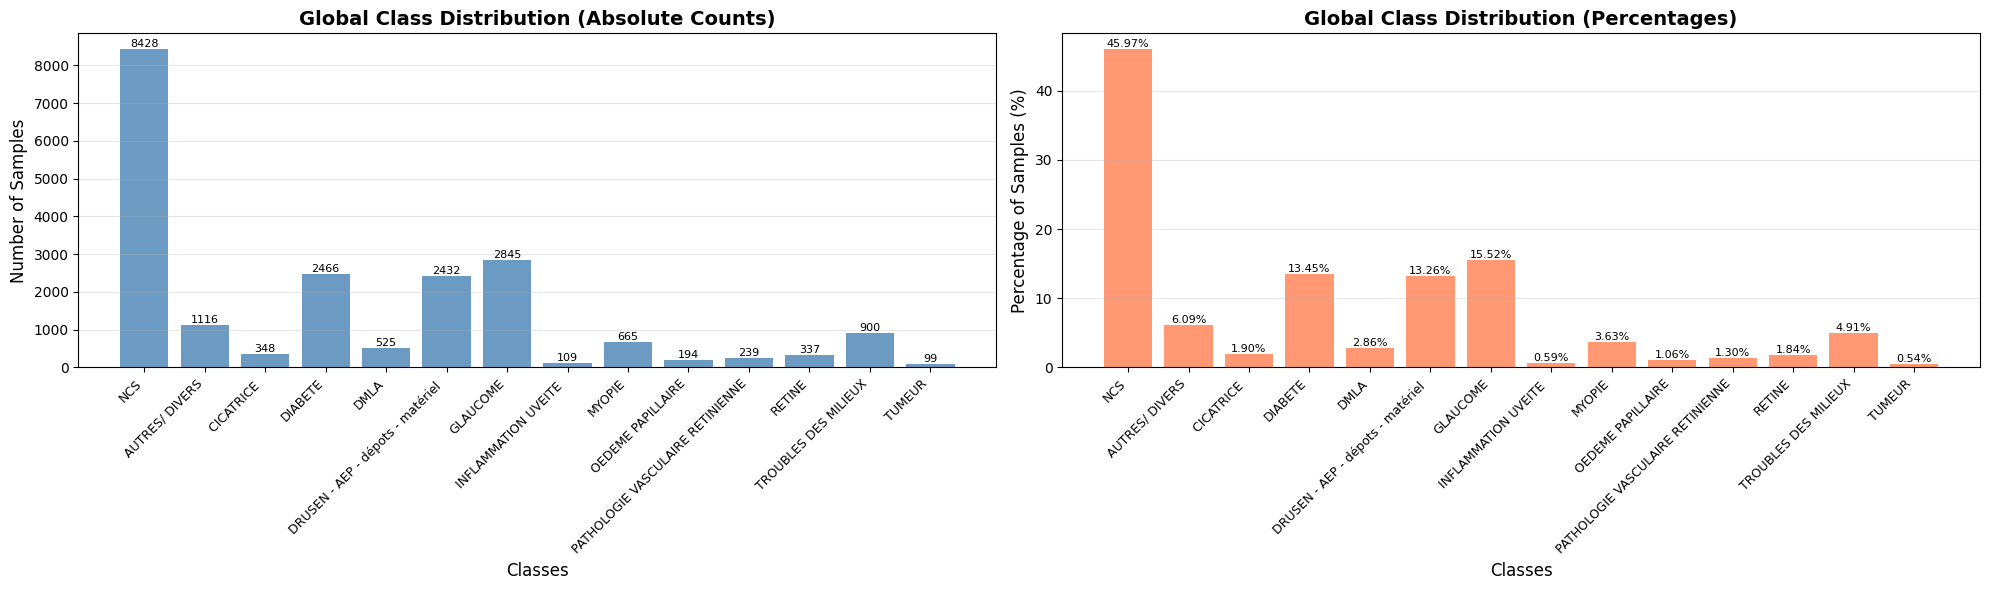

GLOBAL DATASET STATISTICS - data_patho_matrix_full.csv

Total samples: 18335

Class distributions:
  NCS: 8428 (45.97%)
  AUTRES/ DIVERS: 1116 (6.09%)
  CICATRICE : 348 (1.90%)
  DIABETE: 2466 (13.45%)
  DMLA: 525 (2.86%)
  DRUSEN - AEP - dépots - matériel : 2432 (13.26%)
  GLAUCOME: 2845 (15.52%)
  INFLAMMATION UVEITE : 109 (0.59%)
  MYOPIE: 665 (3.63%)
  OEDEME PAPILLAIRE: 194 (1.06%)
  PATHOLOGIE VASCULAIRE RETINIENNE: 239 (1.30%)
  RETINE: 337 (1.84%)
  TROUBLES DES MILIEUX: 900 (4.91%)
  TUMEUR: 99 (0.54%)

MULTI-LABEL SAMPLES WITH NCS

Total samples with NCS: 8428
Samples with NCS AND at least one other label: 114
Percentage of NCS samples that are multi-label: 1.35%

MULTI-LABEL STATISTICS

Average number of labels per sample: 1.13
Min labels per sample: 1
Max labels per sample: 4

Distribution of number of labels per sample:
  1 label(s): 16215 samples (88.44%)
  2 label(s): 1879 samples (10.25%)
  3 label(s): 234 samples (1.28%)
  4 label(s): 7 samples (0.04%)


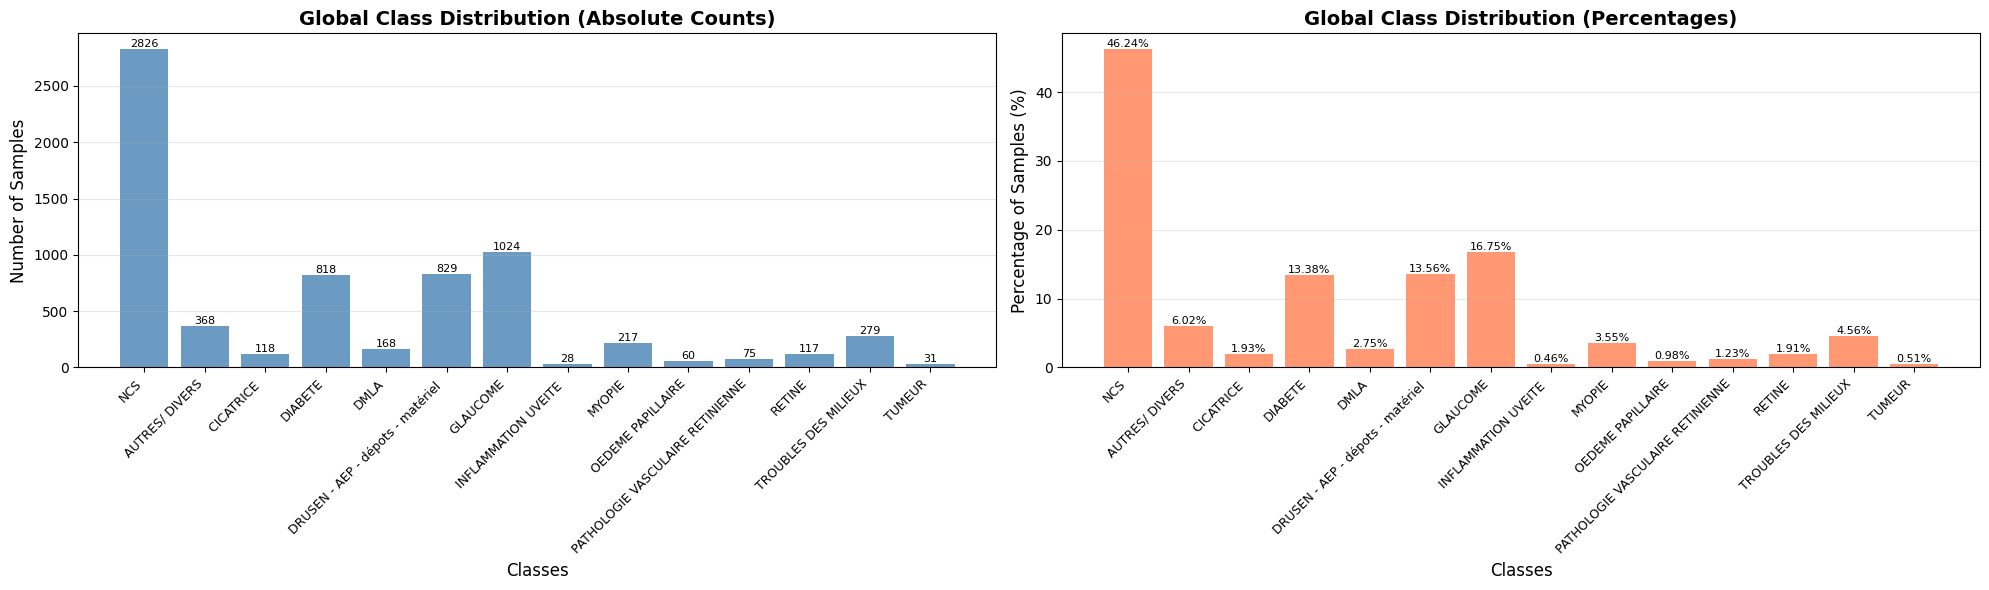

GLOBAL DATASET STATISTICS - data_patho_matrix_full.csv

Total samples: 6112

Class distributions:
  NCS: 2826 (46.24%)
  AUTRES/ DIVERS: 368 (6.02%)
  CICATRICE : 118 (1.93%)
  DIABETE: 818 (13.38%)
  DMLA: 168 (2.75%)
  DRUSEN - AEP - dépots - matériel : 829 (13.56%)
  GLAUCOME: 1024 (16.75%)
  INFLAMMATION UVEITE : 28 (0.46%)
  MYOPIE: 217 (3.55%)
  OEDEME PAPILLAIRE: 60 (0.98%)
  PATHOLOGIE VASCULAIRE RETINIENNE: 75 (1.23%)
  RETINE: 117 (1.91%)
  TROUBLES DES MILIEUX: 279 (4.56%)
  TUMEUR: 31 (0.51%)

MULTI-LABEL SAMPLES WITH NCS

Total samples with NCS: 2826
Samples with NCS AND at least one other label: 38
Percentage of NCS samples that are multi-label: 1.34%

MULTI-LABEL STATISTICS

Average number of labels per sample: 1.14
Min labels per sample: 1
Max labels per sample: 4

Distribution of number of labels per sample:
  1 label(s): 5347 samples (87.48%)
  2 label(s): 686 samples (11.22%)
  3 label(s): 77 samples (1.26%)
  4 label(s): 2 samples (0.03%)

--- Séparation Réussie ---

In [2]:
### NOT UTIL ANYMORE THIS WHEN RUNNED ONCE 

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import sys
import os

# Add the parent directory (or the directory containing 'data') to sys.path so Python can find 'data.stats_global'
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
project_root = os.path.dirname(notebook_dir) if os.path.basename(notebook_dir) == "training" else notebook_dir
sys.path.insert(0, project_root)

from data.stats_global import stats_global


# csv
file_path = '/Users/abelsalmona/Documents/Retinax/Training Repo/data/data_patho_matrix_full.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Dataset chargé avec succès. Nombre total de lignes : {len(df)}")
except FileNotFoundError:
    print(f"ERREUR: Le fichier '{file_path}' n'a pas été trouvé. Veuillez vérifier le chemin.")
    exit()

# split ratio
test_ratio = 0.25
# seed
random_seed = 1

# splitting and shuffling
df_train, df_test = train_test_split(
    df,
    test_size=test_ratio,
    random_state=random_seed,
    shuffle=True
)

# save new csvs
train_file_path = '/Users/abelsalmona/Documents/Retinax/Training Repo/training_data/train_dataset.csv'
val_file_path = '/Users/abelsalmona/Documents/Retinax/Training Repo/training_data/val_dataset.csv'

# index=False to no wright in the new csv
df_train.to_csv(train_file_path, index=False)
df_test.to_csv(val_file_path, index=False)

stats_global(train_file_path, '/Users/abelsalmona/Documents/Retinax/Training Repo/training_data/class_distributions_train.png')
stats_global(val_file_path, '/Users/abelsalmona/Documents/Retinax/Training Repo/training_data/class_distributions_val.png')

# plot
print("\n--- Séparation Réussie ---")
print(f"Ensemble d'entraînement sauvegardé dans : {train_file_path}")
print(f"Nombre de lignes d'entraînement (80%) : {len(df_train)}")
print(f"Ensemble de test sauvegardé dans : {val_file_path}")
print(f"Nombre de lignes de val (20%) : {len(df_test)}")

## GLOBAL IMPORTS

In [1]:
import torch
import wandb
import monai 
import scipy
import torch.nn as nn
import torch.optim as optim
import timm
from earlystopping import EarlyStopping
from losses import AsymmetricLossMultiLabel, AsymmetricLossBinary, CoherenceFactorLoss
from losses import true_negative_accuracy, true_positive_accuracy, simple_accuracy
from losses import TrueNegativeBCELoss, TruePositiveBCELoss, weights, CombinedBCELoss
from model import DeepClassifier, DeepClassifierBinary, DeepClassifierMultiHead
from ocular_dataset import OcularDataset
from tuning_testing import evaluate_with_temperatures
from training_utils import train_model, evaluate_model, plot_losses, CLASSES, train_epoch
from torch.utils.data import DataLoader
from transforms import monai_transform_sequence, val_transform_sequence
from ocular_dataset import OcularDataset


### DATASET LOADING

In [2]:
## train and val with different transforms 
data_dir = "/workspace/data_15"

# binary for now
train_dataset = OcularDataset(
        csv_file="/workspace/Retiniax/training_data/train_dataset.csv",
        data_dir=data_dir,
        transform=monai_transform_sequence,
    )

val_dataset = OcularDataset(
        csv_file="/workspace/Retiniax/training_data/val_dataset.csv",
        data_dir=data_dir,
        transform=val_transform_sequence,
    )

In [3]:
train_loader = DataLoader(
        train_dataset,
        batch_size=8, # SET HERE BATCH SIZE
        shuffle=True, 
        num_workers=8, # SET HERE Workers
        pin_memory=torch.cuda.is_available(), 
    )

val_loader = DataLoader(
        val_dataset,
        batch_size=8, # SET HERE BATCH SIZE
        shuffle=True, 
        num_workers=8, # SET HERE Workers
        pin_memory=torch.cuda.is_available(), 
    )

### MODEL TRAINING AND EVALUATION

In [4]:
# backbone
backbone = timm.create_model('inception_next_base.sail_in1k_384',
                                   in_chans=3, pretrained=False, num_classes=0)

# wrapper
model = DeepClassifier(encoder=backbone, n_classes=14)

/workspace/.miniconda3/lib/python3.13/site-packages/torch/nn/init.py:566: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## Training

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /workspace/.netrc.
wandb: Currently logged in as: abel-salmona (abel-salmona-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training:   0%|          | 0/2292 [00:00<?, ?it/s]

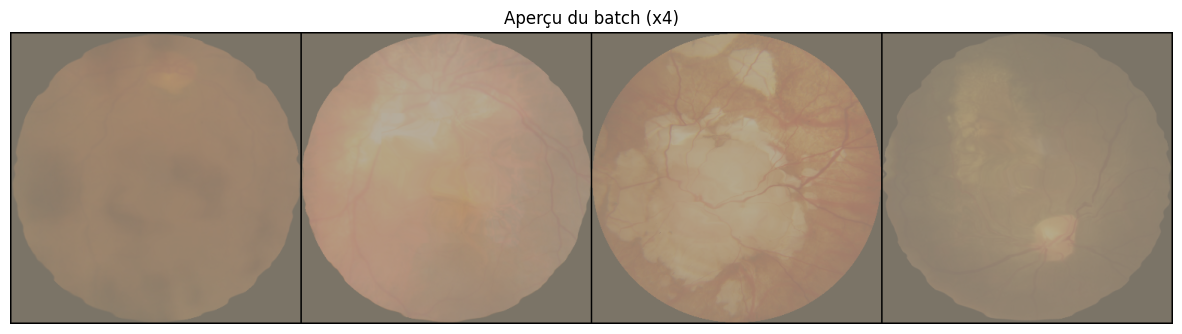

--- Labels associés aux 4 premières images ---
Image 1: TROUBLES
Image 2: DMLA, MYOPIE
Image 3: GLAUCOME, MYOPIE
Image 4: DMLA
--------------------------------------------------


Training:   5%|▍         | 106/2292 [03:35<30:24,  1.20it/s, loss=2.14]  

In [ ]:
# ── Criterion ──
criterion = CombinedBCELoss(w_tp=2.0, w_tn=0.5, class_weight_tp=weights, class_weight_tn=None)

# ── Hyper-parameters ──
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS  = 50
LR      = 1e-4
WD      = 1e-5

model.to(DEVICE)

# All parameters are trainable (encoder NOT frozen)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)


wandb.init(
    project="retiniax-training",
    name="sample_no_freeze",
    config={
        "backbone":        "inception_next_base.sail_in1k_384",
        "n_classes":   14,
        "epochs":          EPOCHS,
        "lr":              LR,
        "weight_decay":    WD,
        "encoder_frozen":  False,
        "criterion":       "CombinedBCELoss, w_tp=1.0, w_tn=1.0, class_weight_tp=weights, class_weight_tn=None",
        "optimizer":       "AdamW",
        "scheduler":       "ReduceLROnPlateau",
    },
)


train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    # ── Train one epoch (uses train_epoch from training_utils) ──
    train_loss = train_epoch(
        model, train_loader, criterion, optimizer,
        device=DEVICE, multi_h=False,
    )
    train_losses.append(train_loss)

    # Benchmark evaluation
    val_loss, tp_acc, tn_acc, tp_bce, tn_bce = evaluate_with_temperatures(
        model, val_loader, num_classes=14, device=DEVICE, threshold=0.5
    )

    val_losses.append(val_loss)

    # ── Scheduler step ──
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    # ── Log everything to wandb ──
    wandb.log({
        "epoch":               epoch + 1,
        "train/loss":          train_loss,
        "val/loss":            val_loss,
        "tp_acc":              tp_acc,
        "tn_acc":              tn_acc,
        "tp_bce":              tp_bce,
        "tn_bce":              tn_bce,
    })

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"TP-Acc: {tp_acc:.4f} | TN-Acc: {tn_acc:.4f} | "
        f"TP-BCE: {tp_bce:.4f} | TN-BCE: {tn_bce:.4f} | "
        f"LR: {current_lr:.2e}"
    )

wandb.finish()
print("Training complete.")

### MODEL TRAINING AND EVALUATION

### PERFORM INFERENCE ON AN IMAGE FOLDER 

### Show top K most confident errors 

## TUTORIAL : Download LabelBox data to a notebook or a workspace 